In [5]:
from lib.data import Mimic2
import numpy as np
from lib.train import Trainer, prepareData
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.regularization import eye_loss, wridge, wlasso, lasso, ridge, owl
from sklearn.metrics import accuracy_score
from lib.utility import get_y_yhat, model_auc
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from main import random_risk_exp, expert_feature_only_exp, reg_exp
import glob
from sklearn.externals import joblib
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
raw_data = []
for fn in glob.glob('models/*.pkl'):
    name = fn.split('/')[-1].split('.pkl')[0]
    name, alpha = name.split('^')
    if 'test' in name: name = name[4:]+'*'
    auc, ap, s1, sp = joblib.load(fn)
    raw_data.append([name, alpha, auc, ap, s1, sp])

df = DataFrame(data=raw_data, columns=['method name', 'alpha', 'auc', 'ap', 'min(rec, prec)', 'sparsity'])
print(df.sort_values(['auc'], ascending=False))

       method name   alpha       auc        ap  min(rec, prec)  sparsity
3  random_risk_eye  0.0001  0.794088  0.164635        0.429907  0.046555
1  random_risk_eye   1e-05  0.794028  0.148544        0.453704  0.043725
0  random_risk_eye   0.001  0.786899  0.207671        0.400000  0.055410
2  random_risk_eye    0.01  0.778176  0.655938        0.423077  0.332041
4  random_risk_eye     0.1  0.735867  0.996665        0.403846  0.880926


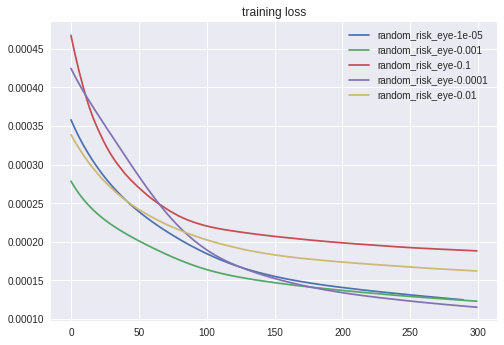

In [12]:
for fn in glob.glob('models/*.loss.npy'):
    name = fn.split('/')[-1].split('.loss')[0]
    name, alpha = name.split('^')
    if 'test' in name: name = name[4:]+'*'
    losses = np.load(fn)
    plt.title("training loss")
    plt.plot(losses, label="%s-%s" % (name, alpha))
    
plt.legend()
plt.show()